In [77]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule

from qiskit.tools.monitor import job_monitor
from numpy import savetxt

import pandas as pd

pi = np.pi
qubit = 0

In [78]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

ibmqfactory.load_account:WARNING:2022-08-28 15:19:15,288: Credentials are already in use. The existing account in the session will be replaced.


In [79]:
scale_factor = 1e-7

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)



In [80]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

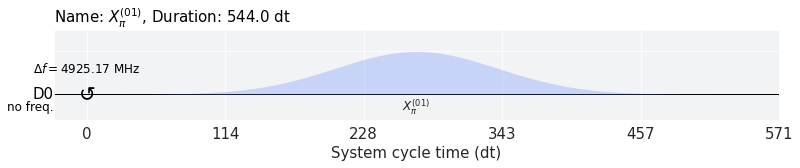

In [81]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                              amp=d01_amplitude,
                              sigma=d01_sigma,
                              name=r'$X_{\pi}^{(01)}$'), drive_chan)

xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

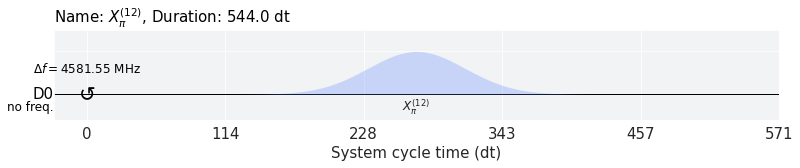

In [82]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                              amp=d12_amplitude,
                              sigma=d12_sigma,
                              name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

In [83]:
# 0 state
ground_circs = QuantumCircuit(1, 1)
ground_circs.measure(0, 0)

# 1 state
one_circs = QuantumCircuit(1, 1)
one_circs.append(xpi01, [0])
one_circs.measure(0, 0)
one_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

# 2 state
two_circs = QuantumCircuit(1, 1)
two_circs.append(xpi01, [0])
two_circs.append(xpi12, [0])
two_circs.measure(0, 0)
two_circs.add_calibration(xpi12, (0,), inst_xpi12, [])
two_circs.add_calibration(xpi01, (0,), inst_xpi01, [])

circs = [ground_circs, one_circs, two_circs]

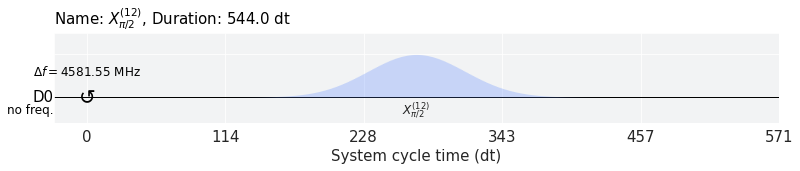

In [84]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(12)}$') as inst_X12_halfpi:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                              amp=d12_amplitude/2,
                              sigma=d12_sigma,
                              name=r'$X_{\pi/2}^{(12)}$'), drive_chan)
inst_X12_halfpi.draw()

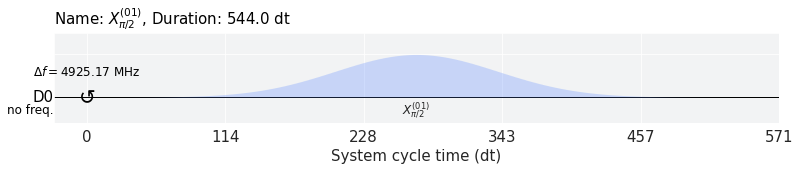

In [85]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(01)}$') as inst_X01_halfpi:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                              amp=d01_amplitude/2,
                              sigma=d01_sigma,
                              name=r'$X_{\pi/2}^{(01)}$'), drive_chan)
inst_X01_halfpi.draw()

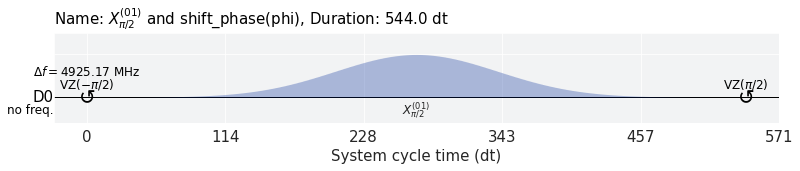

In [86]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(01)}$ and shift_phase(phi)') as inst_Y01_halfpi:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(np.pi/2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=d01_amplitude/2,
                                  sigma=drive_sigma,
                                  name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

inst_Y01_halfpi.draw()

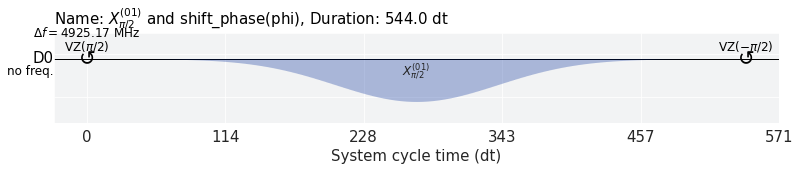

In [87]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(01)}$ and shift_phase(phi)') as inst_Y01_minus_halfpi:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-np.pi/2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=d01_amplitude/2,
                                  sigma=drive_sigma,
                                  name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

inst_Y01_minus_halfpi.draw()

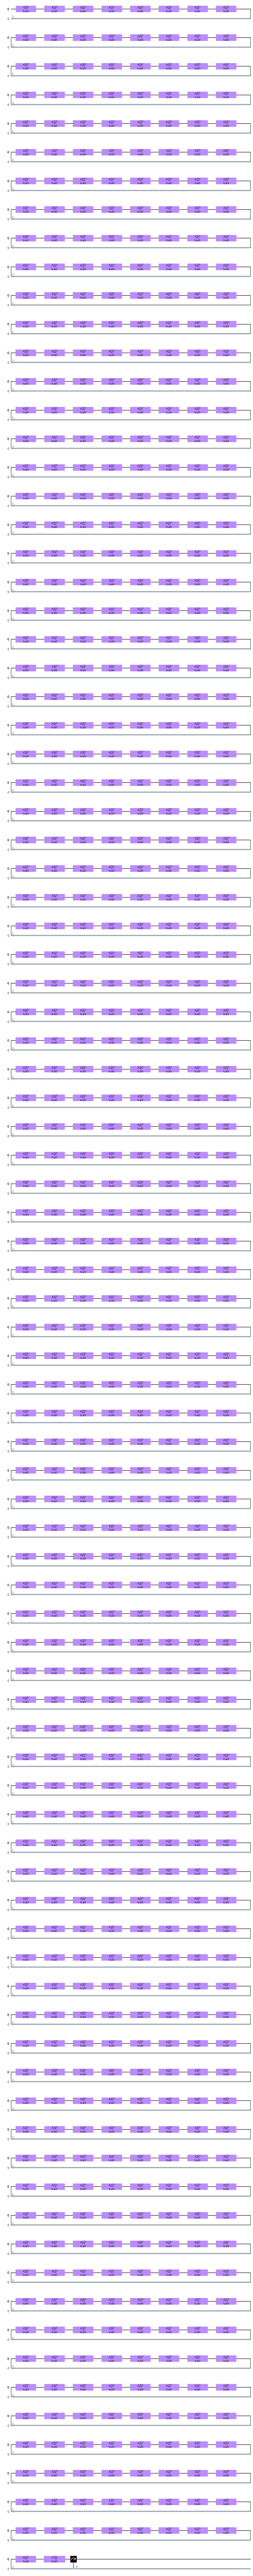

In [88]:
NUM_EXP = 90
param = []
for n in range(NUM_EXP):
    exp_circs = QuantumCircuit(1,1)
    Y01_halfpi = Gate('$Y^{(01)}_{\pi/2}$', 1, [])
    exp_circs.add_calibration(Y01_halfpi, (0,), inst_Y01_halfpi, [])
    Y01_minus_halfpi = Gate('$Y^{(01)}_{-\pi/2}$', 1, [])
    exp_circs.add_calibration(Y01_minus_halfpi, (0,), inst_Y01_minus_halfpi, [])
    X12_halfpi = Gate('$X^{(12)}_{\pi/2}$', 1, [])
    exp_circs.add_calibration(X12_halfpi, (0,), inst_X12_halfpi, [])

    exp_circs.append(Y01_halfpi, [0])
    for j in range(8*n):
        exp_circs.append(X12_halfpi, [0])
    exp_circs.append(Y01_minus_halfpi, [0])
    exp_circs.measure(0,0)

    circs.append(exp_circs)


In [89]:
np.shape(circs)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(93,)

In [91]:
# Assemble the schedules into a program
job = backend.run(circs,
                         meas_level=1,
                         meas_return='single',
                         shots=20000)
job_monitor(job)

Job Status: job has successfully run


In [92]:
# job = backend.retrieve_job('630a2909acf65c4a428086e2')

In [93]:
print(job.job_id())

630b253ba7ff833063784070


In [94]:
raw_ramsey_data = get_job_data(job, average=False)

In [95]:
savetxt('raw_ramsey_data_' + job.job_id() + '.csv', raw_ramsey_data, delimiter=',')

In [96]:
data = pd.read_csv('raw_ramsey_data_' + job.job_id() + '.csv', sep=",", header=None)
data = data.applymap(lambda s: complex(s.replace('i', 'j'))).values

zero_data = data[0]
one_data = data[1]
two_data = data[2]

def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)
two_data_reshaped = reshape_complex_vec(two_data)

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape)  # verify IQ data shape

NUM_SHOTS = 20000

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS)  # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2 * np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

def count(job, discriminator):
    data = get_job_data(job, average=False)
    sched_data = []
    for i in range(len(data)):
        sched_data.append(reshape_complex_vec(data[i]))
    discrim_data = []
    for j in range(len(sched_data)):
        discrim_data.append(discriminator.predict(sched_data[j]))
    final_result = []
    for k in range(len(discrim_data)):
        result = {'0': 0, '1': 0, '2': 0}
        for l in range(len(discrim_data[k])):
            if discrim_data[k][l] == 0.0:
                result['0'] += 1
            elif discrim_data[k][l] == 1.0:
                result['1'] += 1
            elif discrim_data[k][l] == 2.0:
                result['2'] += 1
            else:
                print('Unexpected behavior')
        final_result.append(result)
    return final_result

(60000, 2)
60000


In [97]:
discr_data = count(job, LDA_012)

In [98]:
np.shape(discr_data)

(93,)

In [99]:
ramsey_exp_data = [[discr_data[i]['0']/20000, discr_data[i]['1']/20000, discr_data[i]['2']/20000] for i in range(np.shape(discr_data)[0])]
ramsey_exp_data

[[0.98125, 0.00725, 0.0115],
 [0.01255, 0.966, 0.02145],
 [0.00915, 0.04095, 0.9499],
 [0.91375, 0.0239, 0.06235],
 [0.3462, 0.44375, 0.21005],
 [0.549, 0.2132, 0.2378],
 [0.2116, 0.5444, 0.244],
 [0.4655, 0.38035, 0.15415],
 [0.2702, 0.6509, 0.0789],
 [0.16065, 0.601, 0.23835],
 [0.26285, 0.50485, 0.2323],
 [0.27865, 0.51665, 0.2047],
 [0.5677, 0.31635, 0.11595],
 [0.3954, 0.4669, 0.1377],
 [0.63835, 0.1533, 0.20835],
 [0.46125, 0.3227, 0.21605],
 [0.65315, 0.2031, 0.14375],
 [0.4867, 0.37085, 0.14245],
 [0.482, 0.3435, 0.1745],
 [0.35215, 0.4677, 0.18015],
 [0.26465, 0.5226, 0.21275],
 [0.35075, 0.51525, 0.134],
 [0.27565, 0.53975, 0.1846],
 [0.36485, 0.4682, 0.16695],
 [0.32295, 0.5147, 0.16235],
 [0.45415, 0.3663, 0.17955],
 [0.5079, 0.35115, 0.14095],
 [0.5267, 0.29155, 0.18175],
 [0.5258, 0.3318, 0.1424],
 [0.4895, 0.36155, 0.14895],
 [0.48945, 0.34385, 0.1667],
 [0.4158, 0.40385, 0.18035],
 [0.3784, 0.45035, 0.17125],
 [0.357, 0.5012, 0.1418],
 [0.35195, 0.49945, 0.1486],
 [0.36

In [100]:
savetxt('ramsey_exp_data_' + job.job_id() + '.csv', ramsey_exp_data, delimiter=',')